# Download and process the Bay Area's street network

In [1]:
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox
ox.config(use_cache=True, log_console=True)

In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

### Part 1: download and extract the counties shapefile if it doesn't already exist, then load it

To use OSMnx, we need a polygon of the Bay Area's nine counties. So, we'll download a shapefile from the census, extract our counties, and take the union to form a polygon. Also, project the polygon so we can calculate its area for density stats.

In [3]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [4]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [5]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

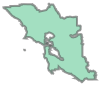

In [6]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [7]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon = bayarea_polygon.convex_hull
bayarea_polygon_proj, crs = ox.project_geometry(bayarea_polygon)

### Part 2: download the street network

Now we've got our polygon. Use OSMnx to download the street network (drivable roads).

In [8]:
# do not simplify yet, we'll strip out unwanted local streets first
G = ox.graph_from_polygon(bayarea_polygon, network_type='drive', simplify=False)

In [9]:
print(len(G.nodes()))
print(len(G.edges()))

1174424
2253232


### Part 3: filter the network to retain only collector streets and up

In [10]:
# identify all the edge types we want to retain
types = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 
         'primary', 'primary_link', 'secondary', 'secondary_link',
         'tertiary', 'tertiary_link', 'unclassified', 'road']

local_streets = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if d['highway'] not in types]

In [11]:
# remove every edge not of these types, then remove isolated nodes
G.remove_edges_from(local_streets)
G = ox.remove_isolated_nodes(G)
print(len(G.nodes()))
print(len(G.edges()))

456218
731986


In [12]:
# retain only the largest connected component subgraph
G_connected = ox.get_largest_component(G, strongly=False)
print(len(G_connected.nodes()))
print(len(G_connected.edges()))

448590
717792


In [13]:
# now simplify the connected graph of major roads
G_simp = ox.simplify_graph(G_connected, strict=True)
print(len(G_simp.nodes()))
print(len(G_simp.edges()))

31051
65257


### Finally: calculate summary stats, save to disk

In [14]:
pd.Series(ox.basic_stats(G_simp, area=bayarea_polygon_proj.area))

circuity_avg                                                             1.11237
count_intersections                                                        28546
edge_density_km                                                          1116.25
edge_length_avg                                                          469.368
edge_length_total                                                    3.06296e+07
intersection_density_km                                                  1.04031
k_avg                                                                    4.20321
m                                                                          65257
n                                                                          31051
node_density_km                                                          1.13161
self_loop_proportion                                                  0.00167032
street_density_km                                                        720.031
street_length_avg           

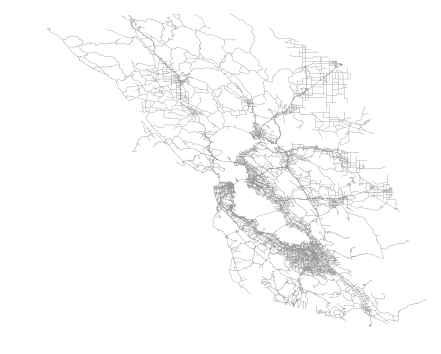

In [15]:
fig, ax = ox.plot_graph(G_simp, node_size=0, edge_linewidth=0.2)

In [16]:
# save it as graphml to use in igraph and other network analysis tools
ox.save_graphml(G_simp, filename='bayarea_simp.graphml')

In [17]:
# save as shapefile for GIS
ox.save_graph_shapefile(G_simp, filename='bayarea_simp')